In [92]:
import re
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras import Sequential
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Dense
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

In [93]:
def get_stockDF(name):
    """
    For real-time, only need to modify this function to get real-time dataframe
    """
    df = pd.read_csv(name)
    df = df.iloc[::-1]
    del df['Unnamed: 0']
    return df
df = get_stockDF("GOOGL_day.csv")

In [94]:
def preprocess(df):
    scaler = MinMaxScaler(feature_range=(0, 1))
    y = df['close']
    y = y.values.reshape(-1,1)
    scaler = scaler.fit(y)
    y = scaler.transform(y)
    return y, scaler
    
stock, scaler = preprocess(df)

In [95]:
n_lookback = 60  # length of input sequences (lookback period)
n_forecast = 30  # length of output sequences (forecast period)

def generate_XY(stock):
    """
    This function will generate X,Y as X train and Y train
    Will be modified to be updated regularly
    """
    X = []
    Y = []

    for i in range(n_lookback, (len(stock)) - n_forecast + 1):
        X.append(stock[i - n_lookback: i])
        Y.append(stock[i: i + n_forecast])

    X = np.array(X)
    Y = np.array(Y)
    return X,Y


In [ ]:
def get_newStockDF():
    return None

In [96]:

def train(X,Y):
    """
    Train model
    """
    np.random.seed(1234)
    tf.random.set_seed(1234)
    model = Sequential()
    model.add(LSTM(units=50,return_sequences=True,input_shape=(n_lookback, 1), activation = 'relu'))
    model.add(LSTM(units=50, return_sequences= True, activation = 'relu'))
    model.add(LSTM(units=30,return_sequences=True, activation = 'relu'))
    model.add(LSTM(units=50, activation = 'relu'))
    model.add(Dense(n_forecast))
    model.compile(optimizer='adam',loss='mean_squared_error')
    model.fit(X, Y,epochs=5,batch_size=32)
    model.summary()
    model.save('future.h5')

def run(stock):
    """
    Run the training algorithm on the historical data
    """
    X_,Y_ = generate_XY(stock)
    train(X_,Y_)


In [97]:
def gen_forecasts(stock):
    """
    Generate forecasts from the updated model
    @stock: preprocessed stock variable
    @return: Y_ the forecast prices for the next 30 days
    """

    model = tf.keras.models.load_model('future.h5')

    X_ = stock[-n_lookback:]  # last available input sequence
    X_ = X_.reshape(1, n_lookback, 1)

    Y_ = model.predict(X_).reshape(-1, 1)
    Y_ = scaler.inverse_transform(Y_)

    return Y_


In [98]:
"""Data frame of the forecasts
#Append two of them to the variable results
Plot both
"""
def gen_dfPast(df):
    df_past = df[['close']]
    df_past['date'] = pd.to_datetime(df['date'])
    df_past['forecast'] = np.nan
    return df_past
def gen_dfFuture(df_past, forecast):
    df_future = pd.DataFrame(columns=['close', 'date', 'forecast'])
    df_future['date'] = pd.date_range(start=df_past['date'].iloc[-1] + pd.Timedelta(minutes=1), periods=n_forecast)
    df_future['forecast'] = forecast.flatten()
    results = df_past.append(df_future).set_index('date')
    return results, df_future

def plot_pred(results):
    plt.figure(figsize=(16,6))
    plt.title('30 days predictions')
    plt.plot(results)
    #Uncomment this when real-time is fully implemented
    # plt.savefig('real1.png', dpi = 300, bbox_inches = 'tight')

In [99]:
def plot_pred2(df_future):
    future = df_future.set_index('date')
    future.plot()

In [100]:
run(stock)

Epoch 1/5
37/37 [==============================] - 3s 39ms/step - loss: 0.1589
Epoch 2/5
37/37 [==============================] - 1s 38ms/step - loss: 0.0559
Epoch 3/5
37/37 [==============================] - 1s 39ms/step - loss: 0.0081
Epoch 4/5
37/37 [==============================] - 2s 41ms/step - loss: 0.0044
Epoch 5/5
37/37 [==============================] - 2s 41ms/step - loss: 0.0041
Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_32 (LSTM)              (None, 60, 50)            10400     
                                                                 
 lstm_33 (LSTM)              (None, 60, 50)            20200     
                                                                 
 lstm_34 (LSTM)              (None, 60, 30)            9720      
                                                                 
 lstm_35 (LSTM)              (None, 50)                

1/1 [==============================] - 0s 251ms/step


/var/folders/x5/l8x4kr756xq3xt39yzgv1_b80000gn/T/ipykernel_33892/3668046746.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_past['date'] = pd.to_datetime(df['date'])
/var/folders/x5/l8x4kr756xq3xt39yzgv1_b80000gn/T/ipykernel_33892/3668046746.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_past['forecast'] = np.nan
/var/folders/x5/l8x4kr756xq3xt39yzgv1_b80000gn/T/ipykernel_33892/3668046746.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future ve

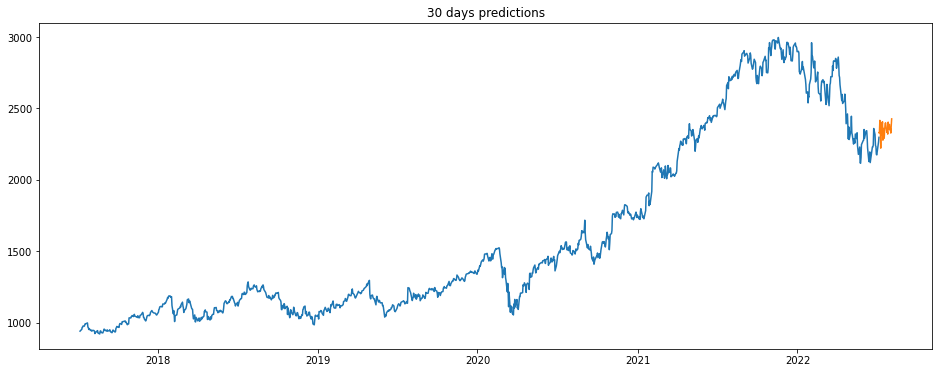

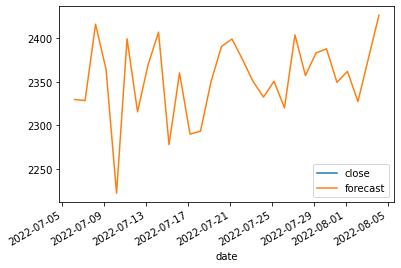

In [101]:
def run_stock():
    forecast = gen_forecasts(stock)
    dfPast = gen_dfPast(df)
    results, dfFuture = gen_dfFuture(dfPast, forecast)
    plot_pred(results)
    plot_pred2(dfFuture)
run_stock()